In [1]:
from files.utils.constants import *
from files.utils.dataset_creator import *
from files.utils.utility_functions import *

# from files.NeuralRansac import *
from files.pif.pif import *
from files.models.base_models import *

import re

In [13]:
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress([1, 1], [1, 2])
slope, intercept

(nan, nan)

In [3]:
def load_dataset_line(name):
    with open(joinpath("..", "..", "..", "datasets", "2d", "lines", "no_outliers", f"{name}.csv"), 'r') as f:
        content = f.read().split("\n")
        content.remove("")
        
        X = np.array(content[0].split(","), dtype=float)
        y = np.array(content[1].split(","), dtype=float)
        ds = np.dstack((X, y))[0]
        

    with open(joinpath("..", "..", "..", "datasets", "2d", "lines", "no_outliers", f"{name}_gt.csv"), 'r') as f:
        real_gt = np.array([int(float(l)) for l in f.read().split("\n") if l != ''])
    
    return ds, real_gt

def load_dataset_circle(name):
    with open(joinpath("..", "..", "..", "datasets", "2d", "circles", "no_outliers", f"{name}.csv"), 'r') as f:
        content = f.read().split("\n")
        content.remove("")
        
        X = np.array(content[0].split(","), dtype=float)
        y = np.array(content[1].split(","), dtype=float)
        ds = np.dstack((X, y))[0]
        

    with open(joinpath("..", "..", "..", "datasets", "2d", "circles", "no_outliers", f"{name}_gt.csv"), 'r') as f:
        real_gt = np.array([int(float(l)) for l in f.read().split("\n") if l != ''])
    
    return ds, real_gt

Model: stair3
	Dataset 0, std: 0.0027
	Dataset 1, std: 0.0029
	Dataset 2, std: 0.0032
Std to use with stair3 dataset: 0.003


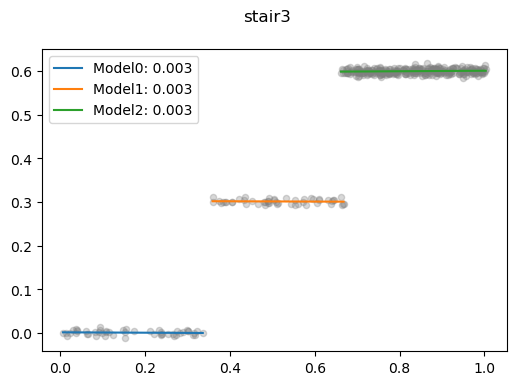

Model: stair4
	Dataset 0, std: 0.004
	Dataset 1, std: 0.0042
	Dataset 2, std: 0.0045
	Dataset 3, std: 0.0044
Std to use with stair4 dataset: 0.004


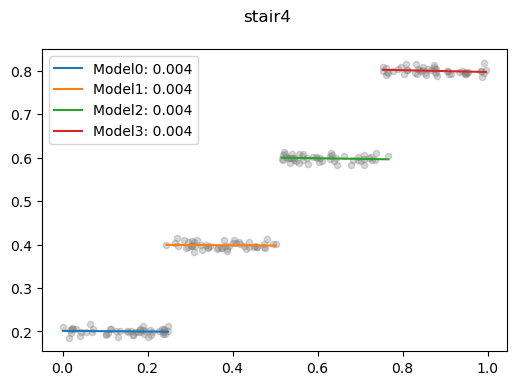

Model: star5
	Dataset 0, std: 0.0068
	Dataset 1, std: 0.0085
	Dataset 2, std: 0.2842
	Dataset 3, std: 0.0095
	Dataset 4, std: 0.0081
Std to use with star5 dataset: 0.009


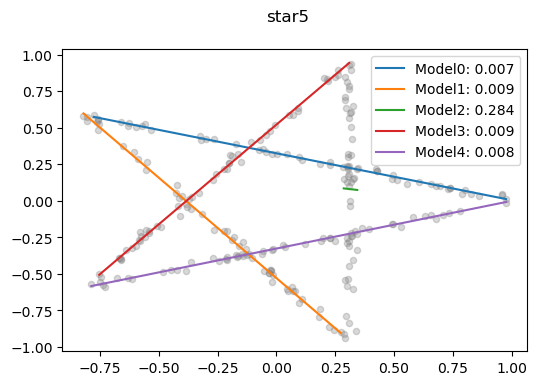

Model: star11
	Dataset 0, std: 0.0036
	Dataset 1, std: 0.0046
	Dataset 2, std: 0.005
	Dataset 3, std: 0.0048
	Dataset 4, std: 0.0041
	Dataset 5, std: 0.112
	Dataset 6, std: 0.0043
	Dataset 7, std: 0.0036
	Dataset 8, std: 0.0046
	Dataset 9, std: 0.0049
	Dataset 10, std: 0.0048
Std to use with star11 dataset: 0.005


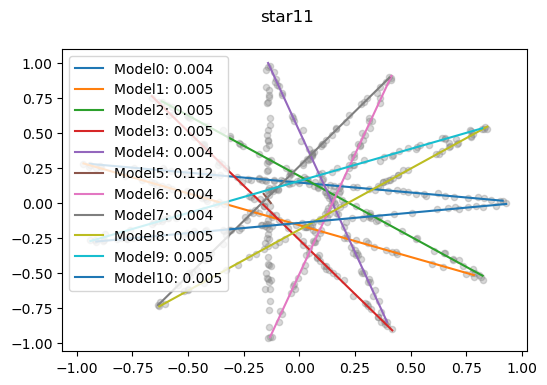

In [4]:
from scipy import stats
names = ["stair3", "stair4", "star5", "star11"]

for name in names:
    ds, real_gt = load_dataset_line(name)
    num_models = int("".join(re.findall('\d', name)))

    num_points = len(np.where(real_gt!=0)[0])

    print(f"Model: {name}")

    trials = 1000
    lines = []
    results = np.zeros(shape=(num_models, trials))
    for i in range(1, num_models+1):
        slopes, intercepts = [], []

        for k in range(trials):
            model_points = ds[real_gt==i]

            slope, intercept, r_value, p_value, std_err = stats.linregress(model_points[:,0],model_points[:,1])
# 
            line = LineEstimator()
            line.slope = slope # r.estimator_.coef_[0][0]
            line.intercept = intercept # r.estimator_.intercept_[0]
            

            residuals = line.get_residuals(model_points)
            slopes.append(slope)
            intercepts.append(intercept)

            results[i-1,k] = residuals.std()

        X = np.linspace(model_points.min(axis=0)[0], model_points.max(axis=0)[0], 100)
        lines.append(np.dstack((X, np.mean(slopes)*X + np.mean(intercepts)))[0])

    for idx, s in enumerate(results):
        print(f"\tDataset {idx}, std: {round(results[idx].mean(), 4)}")
    print(f"Std to use with {name} dataset: {round(np.median(results), 3)}")

    plot(ds, new_fig=True, c='gray', alpha=0.3, title=name, dpi=100)
    for i, l in enumerate(lines):
        plt.plot(l[:,0], l[:,1], label=f"Model{i}: {round(results[i].mean(), 3)}")
    plt.legend()
    plt.show()
    

In [5]:
from scipy import optimize

def estimate_circle(data):
    x, y = data[:,0], data[:,1]
    def calc_R(xc, yc):
        """ calculate the distance of each data points from the center (xc, yc) """
        return np.sqrt((x-xc)**2 + (y-yc)**2)

    def f_2b(c):
        """ calculate the algebraic distance between the 2D points and the mean circle centered at c=(xc, yc) """
        Ri = calc_R(*c)
        return Ri - Ri.mean()

    def Df_2b(c):
        """ Jacobian of f_2b
        The axis corresponding to derivatives must be coherent with the col_deriv option of leastsq"""
        xc, yc     = c
        df2b_dc    = empty((len(c), x.size))

        Ri = calc_R(xc, yc)
        df2b_dc[0] = (xc - x)/Ri                   # dR/dxc
        df2b_dc[1] = (yc - y)/Ri                   # dR/dyc
        df2b_dc    = df2b_dc - df2b_dc.mean(axis=1)[:, np.newaxis]

        return df2b_dc

    center, ier = optimize.leastsq(f_2b, (0,0), Dfun=Df_2b, col_deriv=True)

    return center, calc_R(*center).mean()    # center (x, y), radius r


Model: circle3
	Dataset 0, std: 0.00638
	Dataset 1, std: 0.00613
	Dataset 2, std: 0.00621
Std to use with circle3 dataset: 0.006


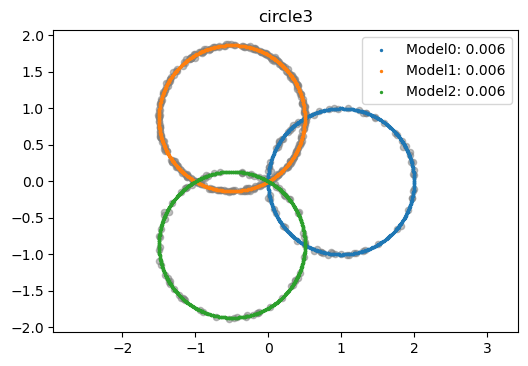

Model: circle4
	Dataset 0, std: 0.00411
	Dataset 1, std: 0.00406
	Dataset 2, std: 0.0033
	Dataset 3, std: 0.00498
Std to use with circle4 dataset: 0.004


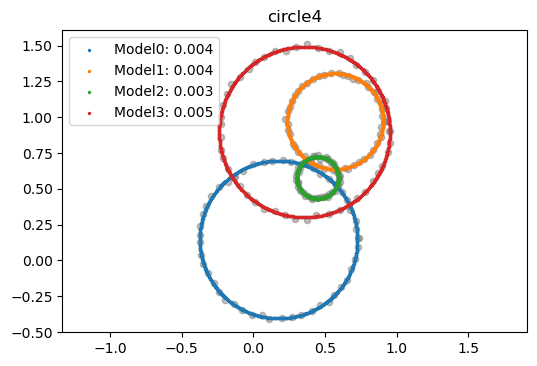

Model: circle5
	Dataset 0, std: 0.00303
	Dataset 1, std: 0.00267
	Dataset 2, std: 0.00295
	Dataset 3, std: 0.00251
	Dataset 4, std: 0.00272
Std to use with circle5 dataset: 0.003


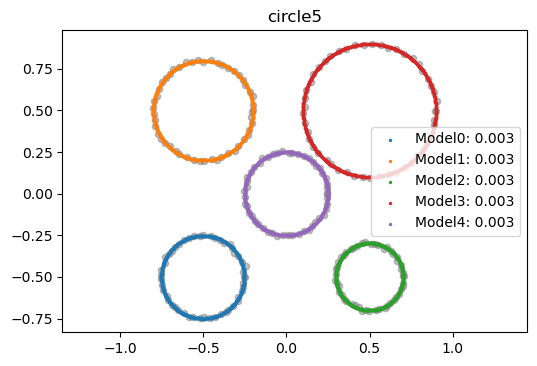

In [7]:

names = ["circle3", "circle4", "circle5"]

for name in names:
    ds, real_gt = load_dataset_circle(name)
    num_models = int("".join(re.findall('\d', name)))

    num_points = len(np.where(real_gt!=0)[0])

    print(f"Model: {name}")

    trials = 1000
    lines = []
    results = np.zeros(shape=(num_models, trials))
    for i in range(1, num_models+1):
        radiuses, centers = [], []

        for k in range(trials):
            model_points = ds[real_gt==i]

            center, r = estimate_circle(model_points)
            circle = CircleEstimator()
            circle.center = center
            circle.radius = r

            residuals = circle.get_residuals(model_points)
            radiuses.append(r)
            centers.append(center)

            results[i-1,k] = residuals.std()

        X = np.linspace(0, 360, 1000)
        r, c = np.mean(radiuses), np.mean(centers, axis=0)
        circle = np.array([[c[0] + np.cos(t)*r, c[1] + np.sin(t)*r] for t in X])
        lines.append(circle)

    for idx, s in enumerate(results):
        print(f"\tDataset {idx}, std: {round(results[idx].mean(), 5)}")

    print(f"Std to use with {name} dataset: {round(np.median(results), 3)}")
    fig, ax = plt.subplots(1, 1, dpi=100)
    ax.axis('equal')
    plot(ds, new_fig=True, c='gray', alpha=0.5, s=20, title=name, ax=ax)
    for i, l in enumerate(lines):
        ax.scatter(l[:,0], l[:,1], s=2, label=f"Model{i}: {round(results[i].mean(), 3)}")
    ax.legend()
    plt.show()